# Multiturn Conversation using Interrupt

In [3]:
from langgraph.graph import add_messages, StateGraph, END, START
from langgraph.types import Command, interrupt
from typing import TypedDict, Annotated, List
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_groq import ChatGroq
import uuid
from dotenv import load_dotenv

load_dotenv()
 

In [4]:
llm = ChatGroq(model="llama3-70b-8192")

class State(TypedDict):
    linkedin_topic: str
    generated_post: Annotated[List[str], add_messages]
    human_feedback: Annotated[List[str], add_messages]

In [5]:
def model(state:State):
    """ Here' we're using the LLM to generate a LinkedIn post with human feedback incorporated"""

    print("[model] Genering Content")
    linkedin_topic = state["linkedin_topic"]
    feedback = state["human_feedback"] if "human_feedback" in state else ["No Feedback yet"]

    # "Here, we define the prompt"
    
    prompt= f"""
LinkedIn Topic : {linkedin_topic}
Human Feeback: {feedback[-1] if feedback else "no feedback yet"} 
Generate a structured and well-written LinkedIn post based on the given topic.

Consider previous human feedback t refine the response
"""

    response = llm.invoke([
        SystemMessage(content="you are an expert LinkedIn content writer"),
        HumanMessage(content=prompt)
    ])

    generated_linkedin_post= response.content

    print(f"[model_node] Generated post: \n {generated_linkedin_post }")

    return {
        "generated_post":[AIMessage(content=generated_linkedin_post)],
        "human_feedback": feedback
    }

In [6]:
def human_node(state:State):
    """ Human Intervention node - loops back to model unless input is done"""

    print("\n [human_node] awaiting human feedback...")

    generated_post = state['generated_post']

    #Interrupt to get user feeback

    user_feedback = interrupt(
        {
            "generated_post": generated_post,
            "message":"Provide feedback or type 'done' to finish    "
        }
    )

    print(f"[human_node] Retrieve human feeback: {user_feedback}")

    #if user types "done", transition to END node 
    if user_feedback.lower()=="done":
        return Command(
            update={"human_feedback":state["human_feedback"]},
            goto = "end_node"
        )
    
    #otherwise, feedback and return to model for re-generation
    return Command(
        update={"human_feedback":state['human_feedback'] + [user_feedback]},
        goto ="model"
    )

In [7]:
def end_node(state:State):
    """Final node"""

    print("\n [end_node] process finished")
    print("Final Generated Post:", state["generated_post"][-1])
    print("Final Human Feedback",state["human_feedback"])
    return {
        "generated_post": state["generated_post"],
        "human_feedback": state["human_feedback"]
    }

In [8]:
graph = StateGraph(State)

graph.add_node("model", model)
graph.add_node("human_node", human_node)
graph.add_node("end_node", end_node)

# Defin the flow

graph.add_edge(START, "model")
graph.add_edge("model", "human_node")
graph.add_edge("end_node", END)

#Enable Interrupt mechanism
checkpointer=MemorySaver()
app = graph.compile(checkpointer=checkpointer)

thread_config = {"configurable":{
    "thread_id": uuid.uuid4()
}}

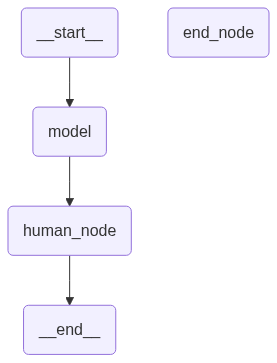

In [11]:
app

In [9]:
linkedin_topic = input("Enter your LinkedIn topic: ")

initial_state = {
    "linkedin_topic": linkedin_topic,
    "generated_post": [],
    "human_feedback": []
}

Enter your LinkedIn topic:  sss


In [10]:
for chunk in app.stream(initial_state, config=thread_config):
    for node_id, value in chunk.items():
        # if we reach an interrupt, continously ask for human feedback

        if(node_id=="__interrupt__"):
            while True:
                user_feedback = input("Provide feedback (or type 'done' when finished): ")

                # resume the graph executioin with the user's feedback
                app.invoke(
                    Command(resume=user_feedback),
                    config=thread_config
                )

                # Exit loop if user says done
                if user_feedback.lower() == "done":
                    break


[model] Genering Content
[model_node] Generated post: 
 I'm happy to help! However, I noticed that the topic "sss" seems to be incomplete or unclear. Could you please provide more context or clarify what you mean by "sss"? 

If you meant to ask about creating a post on Social Security Systems (SSS), I can try to assist you with that. Here's a sample post:

**Title:** The Importance of Social Security Systems in Today's Economy

**Post:**

As we navigate the complexities of modern economics, one crucial aspect often overlooked is the role of Social Security Systems (SSS). These systems serve as a safety net for individuals, providing financial assistance during times of need, such as retirement, disability, or unemployment.

But did you know that SSS also plays a vital role in stabilizing the economy? By redistributing wealth and providing a basic income guarantee, SSS helps to:

Reduce poverty and income inequality
Increase consumer spending, which boosts economic growth
Support vulner

Provide feedback (or type 'done' when finished):  done



 [human_node] awaiting human feedback...
[human_node] Retrieve human feeback: done

 [end_node] process finished
Final Generated Post: content='I\'m happy to help! However, I noticed that the topic "sss" seems to be incomplete or unclear. Could you please provide more context or clarify what you mean by "sss"? \n\nIf you meant to ask about creating a post on Social Security Systems (SSS), I can try to assist you with that. Here\'s a sample post:\n\n**Title:** The Importance of Social Security Systems in Today\'s Economy\n\n**Post:**\n\nAs we navigate the complexities of modern economics, one crucial aspect often overlooked is the role of Social Security Systems (SSS). These systems serve as a safety net for individuals, providing financial assistance during times of need, such as retirement, disability, or unemployment.\n\nBut did you know that SSS also plays a vital role in stabilizing the economy? By redistributing wealth and providing a basic income guarantee, SSS helps to:\n\nRedu